In [1]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib 

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
def normalise(array):
    # ((X - X_min)/(X_max - X_min) * 2) - 1
    min_value = array.min()
    max_value = array.max()
    
    normalised_array = ((array - min_value)/(max_value - min_value) * 2) - 1
    
    return normalised_array

def make_n_dimensional_ndarray(features):
    return np.array(features).transpose()

def normalise_all_columns(ndarray):
    cols = ndarray.shape[1]
    columns = []
    for i in range(cols):
        unnormalised = np.array([element[i] for element in ndarray])
        normalised = normalise(unnormalised)
        columns.append(normalised)
    return np.array(columns).transpose()


In [3]:
# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    
    x_range = x_max - x_min
    y_range = y_max - y_min
    
    padding_ratio = 0.1
    
    x_pad = x_range * padding_ratio
    y_pad = y_range * padding_ratio
    
    x_h = x_range / 1000
    y_h = y_range / 1000
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(
        np.arange(x_min - x_pad, x_max + x_pad, x_h),
        np.arange(y_min - y_pad, y_max + y_pad, y_h)
    )
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.figure(figsize=(20,20))
#     plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.contour(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

In [4]:
# Import house price data
training_data_size = 3000
melbourne_dtypes = {
    'names': ('rooms','price', 'lat', 'lon'),
    'formats': ('float32', 'float32', 'float32', 'float32')
}
melbourne_txns = np.genfromtxt('data/Melbourne_housing_noblanks.csv',
                             delimiter=',', usecols=(2,4,17,18), skip_header=1, 
                             dtype=melbourne_dtypes, max_rows=training_data_size)
print(melbourne_txns[0])

y_prices = np.array([txn[1] for txn in melbourne_txns])
max_price = np.amax(y_prices)

def norm_price(price):
    return (price / (max_price/2)) - 1
def unnorm_price(price):
    return (price + 1)*(max_price/2)

y_norm_prices = norm_price(y_prices)

rooms_unnormalied = np.array([txn[0] for txn in melbourne_txns])
lat_unnormalised = np.array([txn[2] for txn in melbourne_txns])
lon_unnormalised = np.array([txn[3] for txn in melbourne_txns])

X = normalise_all_columns(
    make_n_dimensional_ndarray(
        [lat_unnormalised,
        lon_unnormalised,
        rooms_unnormalied
        ]
    )
)

# X = np.array([[txn[1], txn[2]] for txn in melbourne_txns])

print(y_norm_prices.size)
print(X[1], y_norm_prices[1], unnorm_price(y_norm_prices[1]), y_prices[1])

(2., 1480000., -37.7996, 144.9984)
3000
(array([ 0.06881273,  0.10553539, -0.7777778 ], dtype=float32), -0.6253394, 1034999.9383091927, 1035000.0)


In [13]:
# Imports and config
import tensorflow as tf
import numpy as np

num_of_results = y_prices.size
input_layer_size = 3
hidden_layer_size = 100
output_layer_size = 1
learning_rate=0.1

In [14]:
# Manually-created NN

# Our input layer is the x and y coords
input = tf.placeholder(tf.float32)
target = tf.constant(y_norm_prices)

# Offset in
# offset_in = tf.Variable(tf.random_normal([input_layer_size], 0, 0.1))
# scale_in = tf.Variable(tf.random_normal([input_layer_size], 0, 0.1))
# input_offset = input*scale_in + offset_in
input_offset = input

# Weights for mapping input to HL
weights_W1 = tf.Variable(tf.random_normal([input_layer_size, hidden_layer_size], 0, 0.1))
bias_W1 = tf.Variable(tf.random_normal([hidden_layer_size], 0, 0.1))

# Hidden layer
# h1 = tf.nn.bias_add(tf.matmul(input, weights_W1), bias_W1)
h1 = tf.nn.bias_add(tf.matmul(input_offset, weights_W1), bias_W1)
h2 = tf.tanh(h1)

# Map HL to output
weights_W2 = tf.Variable(tf.random_normal([hidden_layer_size, output_layer_size], 0, 0.1))
bias_W2 = tf.Variable(tf.random_normal([output_layer_size], 0, 0.1))

# Output layer
yhat = tf.nn.bias_add(
        tf.matmul(h2, weights_W2),
        bias_W2)

# Offset out
offset_out = tf.Variable(tf.random_normal([output_layer_size], 0, 0.1))
scale_out = tf.Variable(tf.random_normal([output_layer_size], 1000000, 0.1))
yhat_out = yhat*scale_out + offset_out

# Hidden layer 2
weights_W1b = tf.Variable(tf.random_normal([hidden_layer_size, hidden_layer_size], 0, 0.1))
bias_W1b = tf.Variable(tf.random_normal([hidden_layer_size], 0, 0.1))
h3 = tf.matmul(h2, weights_W1b)
# h3 = tf.nn.bias_add(tf.matmul(h2, weights_W1b), bias_W1b)
h4 = tf.tanh(h3)
# h4 = tf.sigmoid(h3)
yhat = tf.nn.bias_add(
        tf.matmul(h4, weights_W2),
        bias_W2)

# Hidden layer 3
weights_W1c = tf.Variable(tf.random_normal([hidden_layer_size, hidden_layer_size], 0, 0.1))
bias_W1c = tf.Variable(tf.random_normal([hidden_layer_size], 0, 0.1))
# h5 = tf.matmul(h4, weights_W1c)
h5 = tf.nn.bias_add(tf.matmul(h4, weights_W1c), bias_W1c)
h6 = tf.tanh(h5)
yhat = tf.nn.bias_add(
        tf.matmul(h6, weights_W2),
        bias_W2)


# Compute the error
# yerror = tf.reduce_logsumexp(tf.subtract(yhat, target))
# yerror = tf.reduce_logsumexp(tf.subtract(yhat_out, target))
yerror = tf.divide(tf.subtract(yhat_out, target), training_data_size)
loss = tf.nn.l2_loss(yerror)
# loss = yerror

# Optimise the weights
# update_weights = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
update_weights = tf.train.AdamOptimizer().minimize(loss)

In [15]:
# Train NN and predict

losses = []
training_steps = 1000
epochs = 20
sample_size = 500

saver = tf.train.Saver()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    for j in range(epochs):
        # Test
        
        # Take random sample
        sample_indexes = np.random.randint(0, high=training_data_size-1, size=10)
        X_sample = X[sample_indexes]
        
        # Train on sample
        for i in range(training_steps):
            sess.run(update_weights, feed_dict = {input: X_sample})

            loss_ = loss.eval(feed_dict = {input: X_sample})
            losses.append(loss_)
        
    save_path = saver.save(sess, "./model.ckpt")
    print("Model saved in path: %s" % save_path)

    

Model saved in path: ./model.ckpt


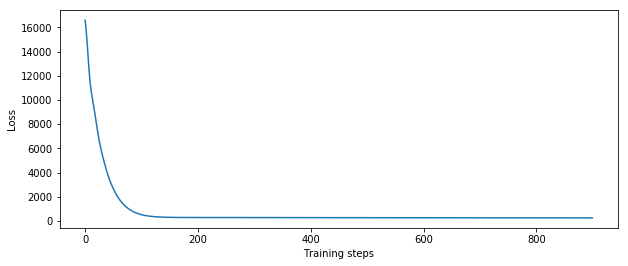

In [16]:
fig, (ax2) = plt.subplots(1)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 4)

skip=100
ax2.plot(range(0, training_steps-skip), losses[skip:training_steps])
ax2.set_ylabel("Loss")
ax2.set_xlabel("Training steps")

plt.show()

In [17]:
example_indexes = np.random.randint(0, high=training_data_size-1, size=10)


with tf.Session() as sess:
  # Restore variables from disk.
    saver.restore(sess, "./model.ckpt")
    print("Model restored.")
    
    def predict(coords):
        return yhat_out.eval(feed_dict = {input: coords})

    examples = X[example_indexes]
    predictions = predict(examples)
    for i in range(9):
        print('Actual: {}, Predicted: {}, X: {}'.format(y_prices[i], int(unnorm_price(predictions[i])), examples[i]))    
#     for n in examples:
#         prediction_area = X[n]
#         prediction = [predict(prediction_area)]
#         print('Actual: {}, Predicted: {}, X: {}'.format(y_prices[n], prediction, prediction_area))
        
    plot_decision_boundary(predict, X, y_prices)

INFO:tensorflow:Restoring parameters from ./model.ckpt
Model restored.
Actual: 1480000.0, Predicted: 414611488, X: [-0.81789315  0.38330305 -0.3333333 ]
Actual: 1035000.0, Predicted: 9923681, X: [ 0.2665745  -0.24591649 -0.7777778 ]
Actual: 1465000.0, Predicted: 40344216, X: [ 0.7907014 -0.5955535 -0.5555556]
Actual: 850000.0, Predicted: 184563888, X: [-0.9464336   0.24537206 -0.3333333 ]
Actual: 1600000.0, Predicted: 557657920, X: [-0.58879006  0.44637024 -0.3333333 ]
Actual: 941000.0, Predicted: -47089088, X: [-0.27399325  0.9072596  -0.5555556 ]
Actual: 1876000.0, Predicted: 544526464, X: [-0.53934175  0.21978223 -0.5555556 ]
Actual: 1636000.0, Predicted: -67712488, X: [ 0.92502594 -0.45934665 -0.5555556 ]
Actual: 300000.0, Predicted: 287907264, X: [-0.7824652  0.5837568 -0.5555556]


InvalidArgumentError: Matrix size-incompatible: In[0]: [1440000,2], In[1]: [3,100]
	 [[Node: MatMul_6 = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_Placeholder_1_0_0, Variable_10/read)]]

Caused by op u'MatMul_6', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 1073, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2818, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-f5bda952e586>", line 19, in <module>
    h1 = tf.nn.bias_add(tf.matmul(input_offset, weights_W1), bias_W1)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_ops.py", line 2018, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_math_ops.py", line 4456, in mat_mul
    name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Matrix size-incompatible: In[0]: [1440000,2], In[1]: [3,100]
	 [[Node: MatMul_6 = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_Placeholder_1_0_0, Variable_10/read)]]
